# Steel Casting Speed Modeling: Advanced Models

Mục tiêu: Đánh giá hiệu quả của hai phương pháp lọc outlier (IQR và Z-score) và áp dụng các mô hình Machine Learning nâng cao (Polynomial, Random Forest, XGBoost) để tối ưu hóa dự đoán tốc độ đúc cho mác thép **sae1006**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
try:
    import xgboost as xgb
except ImportError:
    %pip install xgboost
    import xgboost as xgb

# Cấu hình hiển thị
%matplotlib inline
sns.set(style="whitegrid")

## 1. Chuẩn bị dữ liệu

In [5]:
# Đọc file dữ liệu
file_path = '../01-data/TSC_clean.csv'
try:
    df = pd.read_csv(file_path)
    print("Đọc dữ liệu thành công!")
except FileNotFoundError:
    print(f"File không tồn tại: {file_path}")

# 1. Lọc mác thép Contains 'sae1006'
target_grade = 'sae1006'
df_filtered = df[df['STEEL_GRADE_NAME'].str.contains(target_grade, case=False, na=False)].copy()

# 2. Làm sạch cơ bản
df_clean = df_filtered.dropna(subset=['speed', 'temperature'])
df_clean = df_clean[(df_clean['speed'] > 0) & (df_clean['temperature'] >= 1500)]

print(f"Số lượng mẫu sau khi làm sạch cơ bản (Temp >= 1500): {len(df_clean)}")

C:\Users\vanmaithanhnhat\AppData\Local\Temp\ipykernel_13184\684579793.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Đọc dữ liệu thành công!
Số lượng mẫu sau khi làm sạch cơ bản (Temp >= 1500): 532527


In [6]:
df['HEAT_ID'].nunique()
df.groupby('HEAT_ID')['PROD_COUNTER'].max().sum() / df['HEAT_ID'].nunique()


np.float64(5.823564392274478)

## 2. Lọc Outlier

In [7]:
# Hàm lọc IQR
def filter_iqr(df, cols):
    df_out = df.copy()
    for col in cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    return df_out

# Hàm lọc Z-score
def filter_zscore(df, cols, threshold=3):
    df_out = df.copy()
    z_scores = np.abs(stats.zscore(df_out[cols]))
    df_out = df_out[(z_scores < threshold).all(axis=1)]
    return df_out

# Áp dụng
cols_to_filter = ['speed', 'temperature']

df_iqr = filter_iqr(df_clean, cols_to_filter)
df_zscore = filter_zscore(df_clean, cols_to_filter, threshold=3)

print(f"Số mẫu sau khi lọc IQR: {len(df_iqr)}")
print(f"Số mẫu sau khi lọc Z-score: {len(df_zscore)}")

# Chọn dataset tốt nhất để tiếp tục (Giả định IQR cleaner)
df_final = df_iqr.copy()
print("Selecting IQR filtered dataset for advanced modeling.")

Số mẫu sau khi lọc IQR: 494010
Số mẫu sau khi lọc Z-score: 521351
Selecting IQR filtered dataset for advanced modeling.


In [9]:
df_zscore['LIQUIDUS_TEMP'].unique()

array([1529, 1530, 1528, 1531, 1532, 1516, 1533, 1534, 1527, 1507, 1526,
       1535, 1525, 1510, 1496, 1536, 1345, 1464, 1518, 1538, 1514, 1520,
       1471, 1517, 1519, 1459, 1455, 1522, 1468, 1508, 1524, 1470, 1498,
       1503, 1521, 1523, 1493, 1482, 1515, 1439, 1500, 1497, 1504, 1495,
       1492, 1486, 1485, 1494, 1512, 1490, 1465, 1466, 1505, 1511, 1513,
       1393, 1467, 1506, 1484, 1509])

## 3. Advanced Modeling

Chúng ta sẽ thử nghiệm 3 loại mô hình:
1. **Polynomial Regression (Degree 2, 3)**: Bắt đường cong phi tuyến tính.
2. **Random Forest**: Mô hình Ensemble mạnh mẽ, phi tuyến tính.
3. **XGBoost**: Gradient Boosting, thường cho kết quả tốt nhất trên dữ liệu bảng.

In [35]:
# Prepare Data
X = df_final[['temperature']]
y = df_final['speed']

# Split Train/Test (80/20) để đánh giá thực tế hơn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Danh sách kết quả
models_results = []

### 3.1 Polynomial Regression

c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


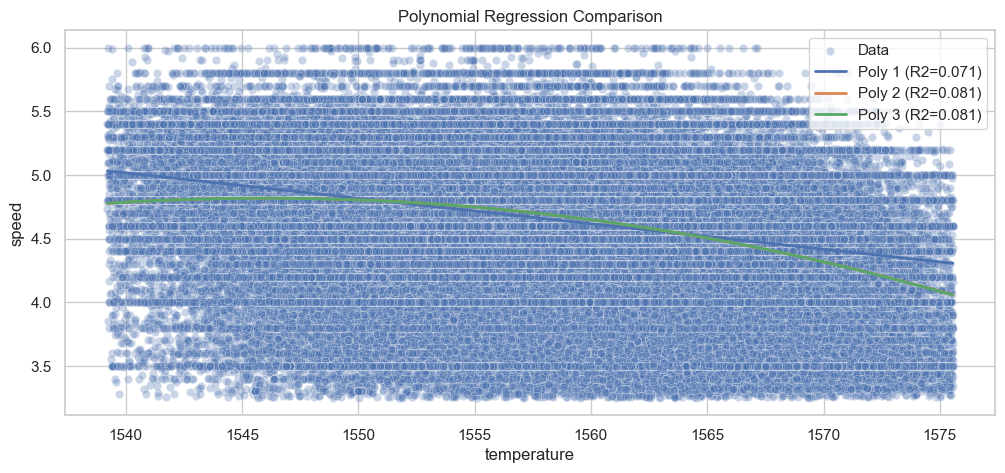

In [36]:
degrees = [1, 2, 3]
plt.figure(figsize=(12, 5))
sns.scatterplot(x='temperature', y='speed', data=df_final, alpha=0.3, label='Data')

for d in degrees:
    poly_features = PolynomialFeatures(degree=d)
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_test = poly_features.transform(X_test)
    
    poly_model = LinearRegression()
    poly_model.fit(X_poly_train, y_train)
    
    y_pred = poly_model.predict(X_poly_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    models_results.append({'Model': f'Poly Degree {d}', 'R2': r2, 'MSE': mse})
    
    # Plot curvea
    X_range = np.linspace(X['temperature'].min(), X['temperature'].max(), 100).reshape(-1, 1)
    y_poly_range = poly_model.predict(poly_features.transform(X_range))
    plt.plot(X_range, y_poly_range, linewidth=2, label=f'Poly {d} (R2={r2:.3f})')

plt.title('Polynomial Regression Comparison')
plt.legend()
plt.show()

### 3.2 Random Forest (Hyperparameter Tuning)

In [37]:
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
models_results.append({'Model': 'Random Forest (Tuned)', 'R2': r2_rf, 'MSE': mse_rf})

print(f"Best RF Params: {grid_rf.best_params_}")

c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
5 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwarg

Best RF Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


### 3.3 XGBoost (Hyperparameter Tuning)

In [38]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
models_results.append({'Model': 'XGBoost (Tuned)', 'R2': r2_xgb, 'MSE': mse_xgb})

print(f"Best XGB Params: {grid_xgb.best_params_}")

Best XGB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


## 4. Tổng hợp Kết quả

,Model,R2,MSE
3,Random Forest (Tuned),0.088353,0.207548
4,XGBoost (Tuned),0.084763,0.208366
2,Poly Degree 3,0.080888,0.209248
1,Poly Degree 2,0.080844,0.209258
0,Poly Degree 1,0.071061,0.211485


c:\Users\vanmaithanhnhat\AppData\Local\miniconda3\envs\kafka-demo\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


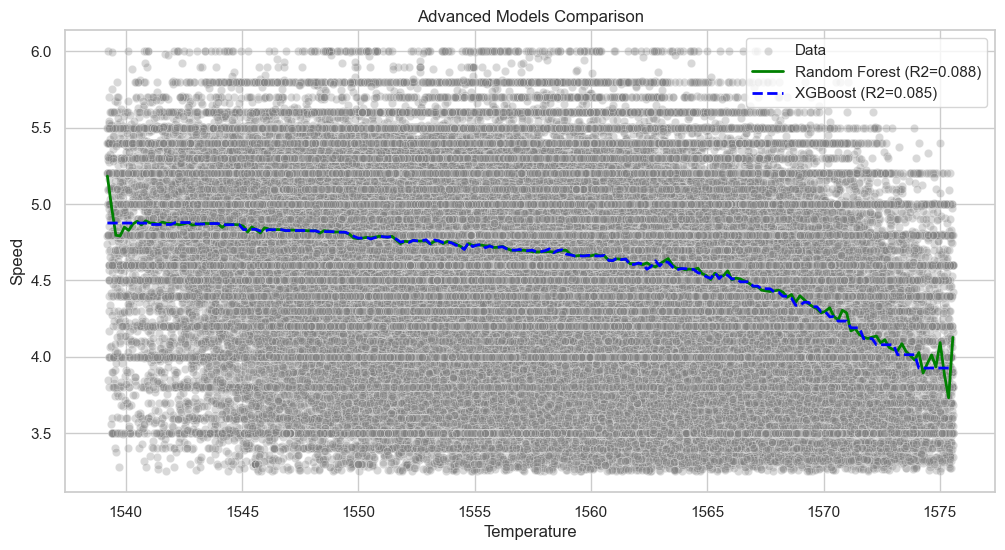

In [39]:
results_df = pd.DataFrame(models_results).sort_values(by='R2', ascending=False)
display(results_df)

# Visualize Best Models
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temperature', y='speed', data=df_final, alpha=0.3, color='gray', label='Data')

X_range = np.linspace(X['temperature'].min(), X['temperature'].max(), 200).reshape(-1, 1)
X_range_df = pd.DataFrame(X_range, columns=['temperature'])

# Plot RF
y_rf_plot = best_rf.predict(X_range_df)
plt.plot(X_range, y_rf_plot, color='green', linewidth=2, label=f'Random Forest (R2={r2_rf:.3f})')

# Plot XGB
y_xgb_plot = best_xgb.predict(X_range_df)
plt.plot(X_range, y_xgb_plot, color='blue', linewidth=2, linestyle='--', label=f'XGBoost (R2={r2_xgb:.3f})')

plt.title('Advanced Models Comparison')
plt.xlabel('Temperature')
plt.ylabel('Speed')
plt.legend()
plt.show()

## 5. Kết luận & Đề xuất

- Quan sát bảng kết quả `R2` và `MSE` để chọn mô hình tốt nhất.
- Nếu **Polynomial** tốt tương đương RF/XGBoost: Nên chọn Polynomial vì đơn giản, dễ giải thích.
- Nếu **RF/XGBoost** vượt trội: Chấp nhận độ phức tạp để đổi lấy độ chính xác. Các mô hình này cũng scale tốt hơn nếu sau này có thêm nhiều features (Độ rộng, Hóa học...).